In [1]:
# Import Libraries and Dependencies
import constrained_optimization
from constrained_optimization.base import*
from constrained_optimization.generate import*

In [2]:
def projsplx(v, s=1):
    assert s > 0, "Radius s must be strictly positive (%d <= 0)" % s
    n, = v.shape  # will raise ValueError if v is not 1-D
    # check if we are already on the simplex
    if v.sum() == s and np.alltrue(v >= 0):
        # best projection: itself!
        return v
    # get the array of cumulative sums of a sorted (decreasing) copy of v
    u = np.sort(v)[::-1]
    cssv = np.cumsum(u)
    # get the number of > 0 components of the optimal solution
    rho = np.nonzero(u * np.arange(1, n+1) > (cssv - s))[0][-1]
    # compute the Lagrange multiplier associated to the simplex constraint
    theta = (cssv[rho] - s) / (rho + 1.0)
    # compute the projection by thresholding v using theta
    w = (v - theta).clip(min=0)
    return w

fmax = lambda x: np.clip(x,0,None)

In [3]:
dimX = 2
dimY = 1
dimU = 0
proj = None

import time
start_time = time.time()
q0, p, q, r, A, b = randQCQPmat(dimX,dimY, proj,True,False, dimU)
print("--- %s seconds ---" % (time.time() - start_time))


--- 0.0019638538360595703 seconds ---


In [4]:
fx, hx, gradf, gradh, hx_opt = toQCQP_opt(p, q, r)

In [5]:
prob = co_problem(fx, (dimX, dimY), hx_opt, None, gradf, gradh, True, A, b)

x = np.ones(dimX+dimY+dimU)
F_co, J_co = prob.get_parameters(False)
print(hx[1](q0[:dimX],1))

0.0


## Adaptive Graal to solve VI

In [6]:
def adaptive_graal(J, F, prox_g, x1, numb_iter=100, phi=1.5, output=False): 
    begin = perf_counter()
    x, x_ = x1.copy(), x1.copy()
    x0 = x + np.random.randn(x.shape[0]) * 1e-9
    Fx = F(x)
    la = phi / 2 * LA.norm(x - x0) / LA.norm(Fx - F(x0))
    rho = 1. / phi + 1. / phi**2
    values = [J(x)]
    diff = [0]
    time_list = [perf_counter() - begin]
    th = 1

    for i in range(numb_iter):
        x1 = prox_g(x_ - la * Fx)
        Fx1 = F(x1)
        if output:
            for j in range(dimY):
                if hx[j+1](x1[:dimX], j+1) > 0:
                    print("UNFEASIBLE")
                    print("hx: ", hx[j+1](x1[:dimX], j+1))
                    continue
            print("iteration: ", i, "\n")
            print("F: ", Fx1, "\n")
            print("x: ", x1[:dimX], "\n")
            print("y: ", x1[dimX:dimX+dimY], "\n")
            print("u: ", x1[dimX+dimY:dimX+dimY+dimU], "\n")
            #print("prox: ", prox_g(x_ - la * Fx, la), "\n")

        n1 = LA.norm(x1 - x)**2
        n2 = LA.norm(Fx1 - Fx)**2
        n1_div_n2 = n1/n2 if n2 != 0 else la*10

        la1 = min(rho * la, 0.25 * phi * th / la * n1_div_n2)
        #values.append(np.linalg.norm(x_-x1)/la)
        x_ = ((phi - 1) * x1 + x_) / phi
        #if output:
            #print (i, la)
        th = phi * la1 / la
        x, la, Fx = x1, la1, Fx1
        #if i%50 == 0: 
            #print("x at iteration ", i , ": ", x)
        temp = values[-1]
        values.append(J(x))
        diff.append(np.absolute(temp - values[-1]))
        time_list.append(perf_counter() - begin)
    end = perf_counter()
    
    for j in range(dimY):
        if hx[j+1](x1[:dimX], j+1) > 0:
            print("UNFEASIBLE")
            print("hx: ", hx[j+1](x1[:dimX], j+1))
    print("CPU time for aGRAAL:", end - begin)
    return values, x, x_, time_list, diff

## Solver of VI

In [7]:
prox_g = prob.prox
# starting point
N = 10000
#q0 = np.ones(dimX + dimY+ dimU)
#print(q0.shape)
#for i in range(dimY):
#    if hx[i+1](q_re, i+1) > 0:
#        print("UNFEASIBLE")
print(q0)

[0.49860026 0.51812518 1.        ]


In [8]:
showout= False
ans1 = adaptive_graal(J_co, F_co, prox_g, q0, numb_iter=N, phi=1.5, output=showout)

CPU time for aGRAAL: 1.0382721999999998


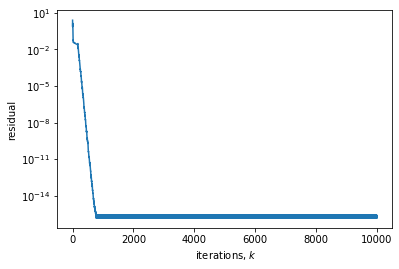

In [9]:
plt.plot(ans1[0])

plt.yscale('log')

plt.xlabel(u' iterations, $k$')
plt.ylabel(u'residual')

#plt.savefig('figures/nash.pdf', bbox_inches='tight')
plt.show()
if showout:
    print("Answer is", ans1[0][-1])
    print("X is", ans1[2])
    print("fx is", fx(ans1[2][0:dimX]))
    #print("diff is",ans1[4])

In [ ]:
print("J is", ans1[0][-1])
X = np.concatenate((ans1[2][:dimX], np.zeros(10)))
#print(X.shape)
Z = ans1[2]
X = ans1[2][:dimX]
Y = ans1[2][dimX:]
print("FX :", Y[0]*gradh[1](X,1))
print("j :", LA.norm(Z-prox_g((Z-F_co(Z)))))
k = 1
print("h ", hx[k](X, k))
print("y: ", ans1[2][dimX:])
print("fx is", fx(ans1[2][0:dimX]))

(F(x)-F(y))@(x-y) >=  for any X,Y 